In [40]:
import pandas as pd
import numpy as np
from scipy import stats
import scanpy as sc

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, binarize
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso

In [22]:
test_data = pd.read_csv('./Data/Multiple/test.csv')
print(test_data.shape)

train_data = pd.read_csv('./Data/Multiple/train.csv')
print(train_data.shape)

(48, 7961)
(380, 7961)


In [23]:
rna_train = train_data.columns[:2708]                       # 2708 rna
scna_train = train_data.columns[2708:5404]                  # 2696 scna
mutation_train = train_data.columns[5404:5591]              # 187 mutation
methy_train = train_data.columns[5591:7957]  

In [4]:
train_features, val_features, train_labels, val_labels = train_test_split(
    train_data.iloc[:, :-3], train_data.iloc[:, -2], test_size=0.2, random_state=42)

test_features, test_labels = test_data.iloc[:, :-3], test_data.iloc[:, -2]

In [38]:
model = RandomForestRegressor()

clf = make_pipeline(StandardScaler(), model) 

clf.fit(train_features, train_labels)

y_pred = clf.predict(test_features) 

def c_index(Prediction, Time_survival, Death, Time):
    '''
        This is a cause-specific c(t)-index
        - Prediction      : risk at Time (higher --> more risky)
        - Time_survival   : survival/censoring time
        - Death           :
            > 1: death
            > 0: censored (including death from other cause)
        - Time            : time of evaluation (time-horizon when evaluating C-index)
    '''
    N = len(Prediction)
    A = np.zeros((N,N))
    Q = np.zeros((N,N))
    N_t = np.zeros((N,N))
    Num = 0
    Den = 0
    for i in range(N):
        A[i, np.where(Time_survival[i] < Time_survival)] = 1
        Q[i, np.where(Prediction[i] > Prediction)] = 1
  
        if (Time_survival[i]<=Time and Death[i]==1):
            N_t[i,:] = 1

    Num  = np.sum(((A)*N_t)*Q)
    Den  = np.sum((A)*N_t)

    if Num == 0 and Den == 0:
        result = -1 # not able to compute c-index!
    else:
        result = float(Num/Den)

    return result
rmse = mean_squared_error(test_labels, y_pred, squared=False)
mae = mean_absolute_error(test_labels, y_pred)
print("RMSE: ", rmse)
print("MAE: ", mae)

# Logistic Regression:
# RMSE:  1207.3487396633445
# MAE:  846.6041666666666

# Lasso
# RMSE:  1221.1997312374897
# MAE:  862.082235831566

# ElasticNet
# RMSE:  1040.882723328859
# MAE:  803.6466015823402

# Gradient Boosting
# RMSE:  973.7958962915109
# MAE:  676.666839893259

# Random Forest
# RMSE:  874.9631619459758
# MAE:  633.3383333333333

# Methylation
# RMSE:  977.7600004566161
# MAE:  702.0275081963855

# Gradient Boosting with RNA-seq alone:
# RMSE:  987.5226036212255
# MAE:  689.2096219224959

# Mutation
# RMSE:  1133.1793115480632
# MAE:  774.4704994851353

# SCNA
# RMSE:  1047.3549517530034
# MAE:  753.5465282620112

RMSE:  874.9631619459758
MAE:  633.3383333333333


In [ ]:
scores = cross_val_score(clf, train_features, train_labels, cv=10, scoring=make_scorer(mean_squared_error))
scores = np.sqrt(scores)
sem = stats.sem(scores)
print(f"Mean RMSE with 95% CI: {np.mean(scores):.3f} ± {sem * 1.96:.3f}")

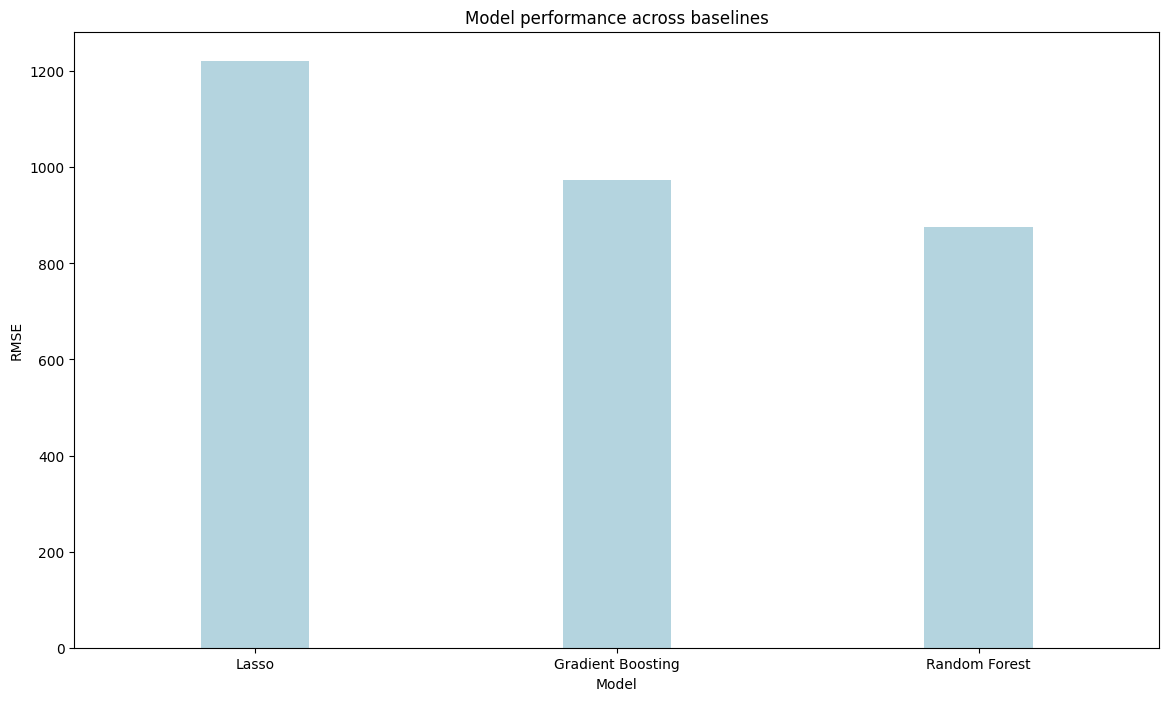

In [53]:
# Test out random noise
plt.figure(figsize=(14, 8))
sns.barplot(x=["Lasso", "Gradient Boosting", "Random Forest"], y=[1221.1997312374897, 973.7958962915109, 874.9631619459758],color="lightblue", width=0.3)
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Model performance across baselines')
plt.rcParams['savefig.dpi']=300
plt.savefig("baselines.png")

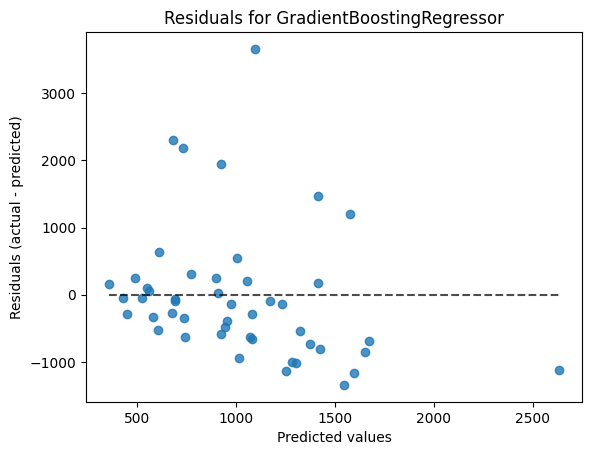

In [27]:
from sklearn.metrics import PredictionErrorDisplay
display = PredictionErrorDisplay(y_true = test_labels, y_pred=y_pred)
display.plot()
plt.title(f"Residuals for {model.__class__.__name__}")
plt.show()